In [151]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(palette='Set2')
import plotly.graph_objects as go

from typing import Tuple

from scipy.stats import norm, skew, kurtosis

import warnings
warnings.filterwarnings('ignore')

import nbimporter
from Functions import get_dollar_bars

## Auxilary Functions

In [152]:
def get_bets_timing(tPos: pd.Series) -> pd.Index:
    '''
    Calculates the timestamps of flattening or flipping trades from target positions series.
    
    Parameters:
        tPos (pd.Series): series with target positions
        
    Returns:
        bets (pd.Index): bets timing
    '''
    df0 = tPos[tPos == 0].index
    df1 = tPos.shift(1)
    df1 = df1[df1 != 0].index
    bets = df0.intersection(df1)    # flattening
    df0 = tPos.iloc[1:] * tPos.iloc[:-1].values
    bets = bets.union(df0[df0 < 0].index).sort_values()    # tPos flips
    if tPos.index[-1] not in bets:
        bets = bets.append(tPos.index[-1:])    # last bet
    return bets

In [153]:
def get_holding_period(tPos: pd.Series) -> float:
    '''
    Derives average holding period (in days) using average entry time pairing algo.
    
    Parameters:
        tPos (pd.Series): series with target positions
        
    Returns:
        hp (float): holding period
    '''
    hp, tEntry = pd.DataFrame(columns=['dT', 'w']), 0.0
    pDiff, tDiff = tPos.diff(), (tPos.index - tPos.index[0]) / np.timedelta64(1, 'D')
    for i in range(1, tPos.shape[0]):
        if pDiff.iloc[i] * tPos.iloc[i - 1] >= 0:    # increased or unchanged
            if tPos.iloc[i] != 0:
                tEntry = (tEntry * tPos.iloc[i - 1] + tDiff[i] * pDiff.iloc[i]) / tPos.iloc[i]
        else:    # decreased
            if tPos.iloc[i] * tPos.iloc[i-1] < 0:    # flip
                hp.loc[tPos.index[i], ['dT', 'w']] = (tDiff[i] - tEntry, abs(tPos.iloc[i - 1]))
                tEntry = tDiff[i]    # reset entry time
            else:
                hp.loc[tPos.index[i], ['dT', 'w']] = (tDiff[i] - tEntry, abs(pDiff.iloc[i]))
    if hp['w'].sum() > 0:
        hp = (hp['dT'] * hp['w']).sum() / hp['w'].sum()
    else:
        hp = np.nan
    return hp

In [154]:
def get_HHI(betRet: pd.Series) -> float:
    '''
    Derives HHI concentration of returns (see p. 200 for definition). Returns can be divided into positive
    and negative or you can calculate the concentration of bets across the months.
    
    Parameters:
        betRet (pd.Series): series with bets returns
        
    Returns:
        hhi (float): concentration
    '''
    if betRet.shape[0] <= 2:
        return np.nan
    wght = betRet / betRet.sum()
    hhi = (wght ** 2).sum()
    hhi = (hhi - betRet.shape[0] ** (-1)) / (1.0 - betRet.shape[0] ** (-1))
    return hhi

In [155]:
def compute_DD_TuW(series: pd.Series, dollars: bool = False) -> Tuple[pd.Series, pd.Series]:
    '''
     Computes series of drawdowns and the time under water associated with them.
    
    Parameters:
        series (pd.Series): series with either returns (dollars=False) or dollar performance (dollar=True)
        dollars (bool): indicator charachterizing series
        
    Returns:
        dd (pd.Series): drawdown series
        tuw (pd.Series): time under water series
    '''
    df0 = series.to_frame('pnl')
    df0['hwm'] = series.expanding().max()
    df1 = df0.groupby('hwm').min().reset_index()
    df1.columns = ['hwm', 'min']
    df1.index = df0['hwm'].drop_duplicates(keep='first').index    # time of hwm
    df1 = df1[df1['hwm'] > df1['min']]    # hwm followed by a drawdown
    if dollars:
        dd = df1['hwm'] - df1['min']
    else:
        dd = 1 - df1['min'] / df1['hwm']
    tuw = ((df1.index[1:] - df1.index[:-1]) / np.timedelta64(1, 'Y')).values    # in years
    tuw = pd.Series(tuw, index=df1.index[:-1])
    return dd, tuw

## Exercises

Here I use the clean dataset generated in Chapter 2. I transform it into dollar bars.

In [156]:
data = pd.read_csv('sp10-19.csv')
# $50,000 per bar
dollar_bars = get_dollar_bars(data['price'].values, data['volume'].values, data['datetime'].values, 50000)
dollar_bars_df = pd.DataFrame(data=dollar_bars[:, 1:], index=dollar_bars[:, 0],
                           columns=['open', 'high', 'low', 'close', 'volume'])
dollar_bars_df = dollar_bars_df[~dollar_bars_df.index.duplicated(keep='first')]

### 1. Compute Statistics, Long Only.

Here I assume that we simply long the contract for the whole period from 2010 to 2019. So the returns are simply the relative increase in bars close price:

In [157]:
returns = (dollar_bars_df['close'] - dollar_bars_df['close'].shift(1)) / dollar_bars_df['close'].shift(1)
returns

2010-01-03 17:00:45.000            NaN
2010-01-03 17:04:29.000    0.000179469
2010-01-03 17:15:11.000     0.00053831
2010-01-03 17:52:34.000      8.967e-05
2010-01-03 18:47:00.000    0.000268986
                              ...     
2019-12-17 07:48:29.219    -0.00131324
2019-12-18 08:11:34.083      0.0014402
2019-12-20 08:11:47.600     0.00909773
2019-12-24 07:26:30.124     0.00666109
2019-12-30 08:08:53.765    -0.00763265
Name: close, Length: 80799, dtype: object

I also create a dataframe for storing all the statistics calculated further.

In [158]:
def get_stats(returns: pd.Series) -> pd.DataFrame:
    returns = returns.dropna()
    
    dd, tuw = compute_DD_TuW(returns.dropna())
    returns_per_year = returns.groupby(pd.Grouper(freq='Y')).count().mean()
    skewness = skew(returns.dropna())
    kurt = kurtosis(returns.dropna())
    sr = returns.mean() / returns.std()
    val = sr * np.sqrt(len(returns) - 1) / np.sqrt(1 - skewness * sr + (kurt - 1) / 4 * sr ** 2)
    var, N, gamma = 0.5, 100, 0.5772
    
    hhi_pos = get_HHI(returns[returns >= 0])
    hhi_pos = get_HHI(returns[returns >= 0])
    hhi_time = get_HHI(returns.groupby(pd.Grouper(freq='M')).count())
    dd_95 = np.quantile(dd, 0.95)
    tuw_95 = np.quantile(tuw, 0.95)
    ann_avr_ret = (returns + 1).prod() ** (0.1) - 1
    avg_hit_ret = returns[returns >= 0].mean()
    avg_miss_ret = returns[returns < 0].mean()
    ann_sr = returns.mean() / returns.std() * returns_per_year ** 0.5
    psr = norm.cdf(val)
    dsr = np.sqrt(var) * ((1 - gamma) * norm.cdf(1 - 1 / N) ** (-1) +
                          gamma * norm.cdf(1 - 1 / N * np.exp(1) ** (-1)) ** (-1))
    
    return pd.DataFrame(data={'statistics': ['HHI_pos', 'HHI_neg', 'HHI_time', 'DD_95th', 'TuW_95th',
                                             'Annualized_Avg_Return', 'Avg_Hit_Return', 'Avg_Miss_Return',
                                             'Ann_SR', 'PSR', 'DSR'],
                              'value': [hhi_pos, hhi_neg, hhi_time, dd_95, tuw_95, ann_avr_ret,
                                        avg_hit_ret, avg_miss_ret, ann_sr, psr, dsr]},
                        dtype=object)

In [159]:
get_stats(returns)

,statistics,value
0,HHI_pos,8.21257e-05
1,HHI_neg,9.7649e-05
2,HHI_time,0.00595024
3,DD_95th,2.95174
4,TuW_95th,4.06383
5,Annualized_Avg_Return,0.112092
6,Avg_Hit_Return,0.000721879
7,Avg_Miss_Return,-0.000863072
8,Ann_SR,0.775973
9,PSR,0.992607


### 2. Compute Statistics, Long on Even Years, Short on Odd Years.

Here we only have to redefine returns and use the same functions to calculate all the statistics.

In [160]:
returns_custom = returns.copy(deep=True)
for ind in returns_custom.index:
    if ind.year % 2 == 1:
        returns_custom[ind] *= -1
returns_custom

2010-01-03 17:00:45.000            NaN
2010-01-03 17:04:29.000    0.000179469
2010-01-03 17:15:11.000     0.00053831
2010-01-03 17:52:34.000      8.967e-05
2010-01-03 18:47:00.000    0.000268986
                              ...     
2019-12-17 07:48:29.219     0.00131324
2019-12-18 08:11:34.083     -0.0014402
2019-12-20 08:11:47.600    -0.00909773
2019-12-24 07:26:30.124    -0.00666109
2019-12-30 08:08:53.765     0.00763265
Name: close, Length: 80799, dtype: object

In [161]:
get_stats(returns_custom)

,statistics,value
0,HHI_pos,9.19837e-05
1,HHI_neg,9.7649e-05
2,HHI_time,0.00595024
3,DD_95th,2.95442
4,TuW_95th,0.756247
5,Annualized_Avg_Return,-0.0461461
6,Avg_Hit_Return,0.000713706
7,Avg_Miss_Return,-0.000870762
8,Ann_SR,-0.235333
9,PSR,0.228376


I also plot the cumulative return of both strategies to see how they performed over the decade:

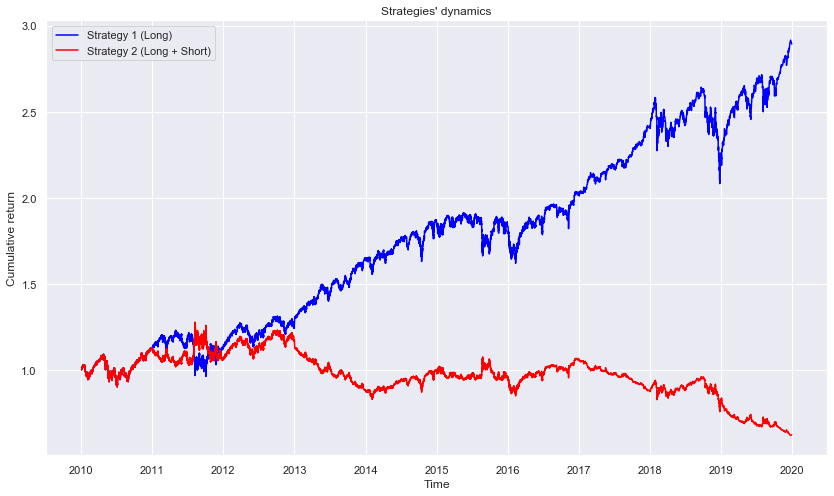

In [162]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot((1 + returns).cumprod(), color='blue', label='Strategy 1 (Long)')
ax.plot((1 + returns_custom).cumprod(), color='red', label='Strategy 2 (Long + Short)')
ax.set_xlabel('Time')
ax.set_ylabel('Cumulative return')
ax.set_title('Strategies\' dynamics')
ax.legend(loc='best')
plt.show()